# Visualisation of NEMO/GEM/Observations using XArray
This notebook demonstrates the use of several tools for easy loading and visualization of model results and drifter observations. Most of these tools require `xarray`, and rather than make them flexible to other packages, I thought I would just demonstrate their use with `xarray` here.

First we'll import the necessary libraries and set our preferred notebook formatting.

In [1]:
from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools
from collections     import OrderedDict
from matplotlib      import animation, patches
from dateutil        import parser

import matplotlib.pyplot as plt
import datetime          as dtm
import os

%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['axes.formatter.useoffset'] = False

## Loading NEMO results, GEM forcing files, and drifter observations
Using the loading tools requires only a timerange argument. There are several additional keyword arguments should you need them.

In [2]:
timerange = ['2016 Jul 1 00:00', '2016 Jul 1 06:00']

### Loading atmospheric forcing data from ERDDAP
GEM2.5 HRDPS atmospheric forcing variables are downloaded from the ERDDAP server and compiled into an `xarray` dataset. Additional variables can be requested using keyword arguments.

In [3]:
GEM  = nc_tools.load_GEM_from_erddap(timerange)
print(GEM)

<xarray.Dataset>
Dimensions:    (gridX: 256, gridY: 266, time: 7)
Coordinates:
  * gridY      (gridY) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * gridX      (gridX) float64 0.0 2.5e+03 5e+03 7.5e+03 1e+04 1.25e+04 ...
  * time       (time) datetime64[ns] 2016-07-01 2016-07-01T01:00:00 ...
Data variables:
    latitude   (gridY, gridX) float32 ...
    longitude  (gridY, gridX) float32 -126.984 -126.956 -126.927 -126.898 ...
    u_wind     (time, gridY, gridX) float64 ...
    v_wind     (time, gridY, gridX) float64 ...


### Loading model results from ERDDAP
Likewise, NEMO results are downloaded from ERDDAP and compiled into an `xarray` dataset, and keyword arguments can be used to request additional variables, or fewer variables to save loading time and memory.

**NOTE** All variables are indexed on the T grid, so the velocities should be unstaggered before use. I didn't want to have to carry around 4 different grids.

In [4]:
NEMO = nc_tools.load_NEMO_from_erddap(timerange)
print(NEMO)

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 6)
Coordinates:
  * gridY        (gridY) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * gridX        (gridX) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * time         (time) datetime64[ns] 2016-07-01T00:30:00 ...
  * depth        (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
Data variables:
    bathymetry   (gridY, gridX) float32 ...
    latitude     (gridY, gridX) float32 ...
    longitude    (gridY, gridX) float32 ...
    u_vel        (time, depth, gridY, gridX) float64 ...
    v_vel        (time, depth, gridY, gridX) float64 ...
    salinity     (time, depth, gridY, gridX) float64 ...
    temperature  (time, depth, gridY, gridX) float64 ...
    mask         (depth, gridY, gridX) int8 ...


### Loading data from the local filespace
You can also load GEM or NEMO results directly from our filespace. This function uses `xarray.mfdataset` which will actually load everything into memory (slow), but distribute across available cores using `dask` (fast). This function is good for loading timeseries of research runs that are not on ERDDAP such as nowcast-green.

In [5]:
nc_tools.load_NEMO_from_path(timerange, model='nowcast-green')

<xarray.Dataset>
Dimensions:      (depth: 40, gridX: 398, gridY: 898, time: 6)
Coordinates:
  * gridX        (gridX) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * gridY        (gridY) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * depth        (depth) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 ...
  * time         (time) datetime64[ns] 2016-07-01T00:30:00 ...
Data variables:
    bathymetry   (gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    latitude     (gridY, gridX) float64 46.86 46.86 46.86 46.87 46.87 46.87 ...
    longitude    (gridY, gridX) float64 -123.4 -123.4 -123.4 -123.4 -123.4 ...
    u_vel        (time, depth, gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    v_vel        (time, depth, gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    salinity     (time, depth, gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    temperature  (time, depth, gridY, gridX) float64 0.0 0.0 0.0 0.0 0.0 0.0 ...
    mask         (depth, gridY,

### Loading drifter data
Romain has all of the drifter results archived as geojson files in his directory on /ocean. They can be loaded using `data_tools.load_drifters`.

In [6]:
DRIFTERS = data_tools.load_drifters()

`DRIFTERS` is a nested dictionary of `xarray` datasets, grouped at the top layer by deployment.

In [7]:
print(DRIFTERS.keys())

odict_keys(['deployment1', 'deployment2', 'deployment3', 'deployment4', 'deployment5', 'deployment6', 'deployment7', 'deployment8', 'deployment9'])


The next layer is drifter ID.

In [8]:
print(DRIFTERS['deployment7'].keys())

odict_keys(['Drifter74', 'Drifter75', 'Drifter76', 'Drifter71', 'Drifter72', 'Drifter73'])


Each drifter is an `xarray` dataset.

In [9]:
print(DRIFTERS['deployment7']['Drifter76'])

<xarray.Dataset>
Dimensions:  (time: 1470)
Coordinates:
  * time     (time) datetime64[ns] 2016-06-28T14:21:35 2016-06-28T14:31:07 ...
Data variables:
    lon      (time) float64 -123.2 -123.2 -123.2 -123.2 -123.2 -123.2 -123.2 ...
    lat      (time) float64 49.03 49.03 49.03 49.03 49.03 49.03 49.02 49.02 ...


### Data processing
Unstaggering of velocities to the T grid is done explicitly with respect to dimension (e.g., zonal velocity is shifted in the x-direction). Unstaggering also preserves the `xarray` structure. Lazy loading cannot survive this step, so this process can be time-consuming for large ERDDAP requests.

In [10]:
NEMO['u_vel'] = viz_tools.unstagger_xarray(NEMO.u_vel, 'gridX')
NEMO['v_vel'] = viz_tools.unstagger_xarray(NEMO.v_vel, 'gridY')

## Visualisation
There are two main functions that handle model visualisation: `visualisations.plot_tracers`, and `visualisations.plot_velocities`. For simplicity, both accept `xarray` Datasets as inputs, and the field names are assumed to be consistent with the conventions shown above for loading data. Changing `xarray` field names on the fly and merging DataArrays is fairly straight-forward and can be found in the `xarray` documentation. These functions should be well-suited for most simple model visualisation applications, perhaps with a little modification.

First, to reduce clutter, we'll make a function `create_figure` for all of our boilerplate plot formatting. This function will identify the type of slice based on the shape of the NEMO results `xarray.Dataset`, `DATA`. This function uses the NEMO bathymetry for masking coastlines, and the NEMO 3-D mesh mask (`viz_tools.plot_boundary`) for masking depth slices.

In [11]:
def create_figure(DATA, window=[-125, -122.5, 48, 50], figsize=[15, 8]):
    """
    """
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Determine orientation based on indexing
    if   not DATA.gridY.shape: # Cross-strait slice
        viz_tools.plot_boundary(ax, DATA)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Depth [m]')
    
    elif not DATA.gridX.shape: # Along-strait slice
        viz_tools.plot_boundary(ax, DATA)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Depth [m]')
    
    else: # Plan view
        #viz_tools.plot_land_mask(ax, DATA, coords='map', color='burlywood', server='ERDDAP')
        #viz_tools.plot_coastline(ax, DATA, coords='map', server='ERDDAP')
        viz_tools.plot_boundary(ax, DATA)
        viz_tools.set_aspect(ax)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid()
    
    # Axis limits
    ax.set_xlim(window[0:2])
    ax.set_ylim(window[2:4])
    
    return fig, ax

### Tracers
The tracer plotting routine `visualisations.plot_tracers` accepts any 2-D slice of the NEMO or GEM Dataset and plots the orientation accordingly. Here we have a plan view of surface salinity. There is also an option to plot in grid coordinates instead of map coordinates.

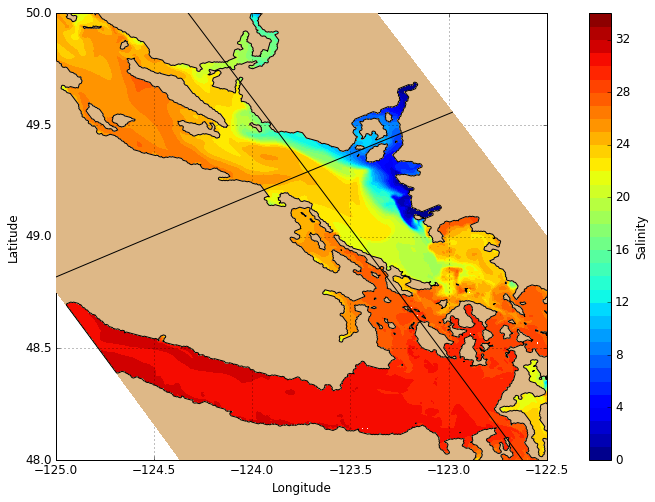

In [12]:
# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Plot surface salinity
C_sal = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, depth=0))
cbar = fig.colorbar(C_sal, label='Salinity')

# Plot sections
ax.plot(NEMO.longitude.isel(gridY=493), NEMO.latitude.isel(gridY=493), 'k-', zorder=10)
ax.plot(NEMO.longitude.isel(gridX=255), NEMO.latitude.isel(gridX=255), 'k-', zorder=10)

With a different 2-D slice we obtain a cross-section along the section track shown above. The white space appears because the mesh mask is based on the new bathymetry but the results being plotted are not. This will be fixed down the road.

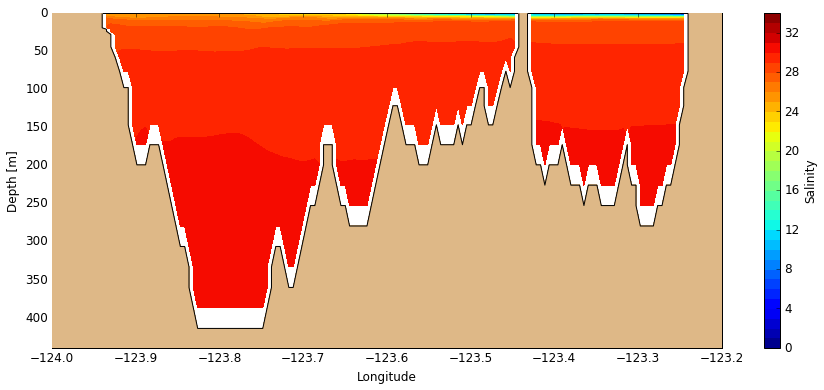

In [13]:
# Create figure
fig, ax = create_figure(NEMO.isel(time=0, gridY=493), window=[-124, -123.2, 440, 0], figsize=[15, 6])

# Plot salinity cross-section
C_sal = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, gridY=493))
cbar = fig.colorbar(C_sal, label='Salinity')

And with another 2-D slice we obtain an along-strait section (track shown above on map).

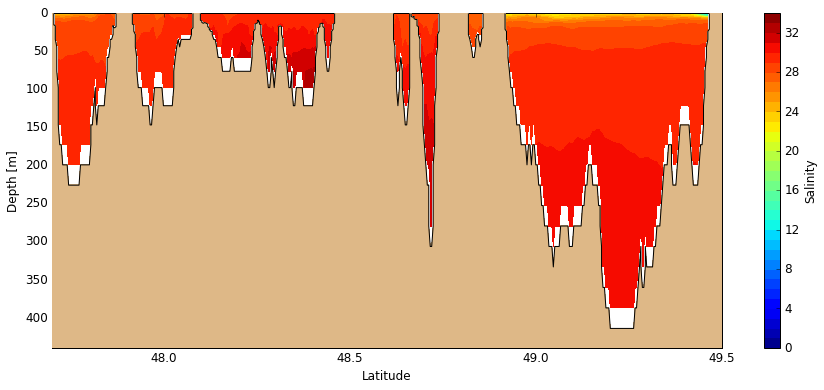

In [14]:
# Create figure
fig, ax = create_figure(NEMO.isel(time=0, gridX=255), window=[47.7, 49.5, 440, 0], figsize=[15, 6])

# Plot salinity along-sections
C_sal = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, gridX=255))
cbar = fig.colorbar(C_sal, label='Salinity')

### Velocities
Velocites are plotted using `visualisations.plot_velocities` which works similarly to `plot_tracers` except only horizontal velocity slices are accepted.

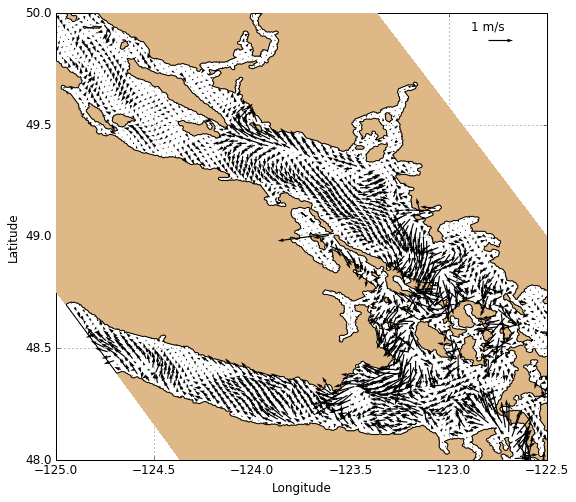

In [15]:
# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Plot surface currents
Q_vel = visualisations.plot_velocity(ax, 'NEMO', NEMO.isel(time=0, depth=0))
Qkey = plt.quiverkey(Q_vel, 0.88, 0.94, 1, '1 m/s', coordinates='axes')

GEM2.5 HRDPS winds can be plotted using the same function, with a few keyword arguments.

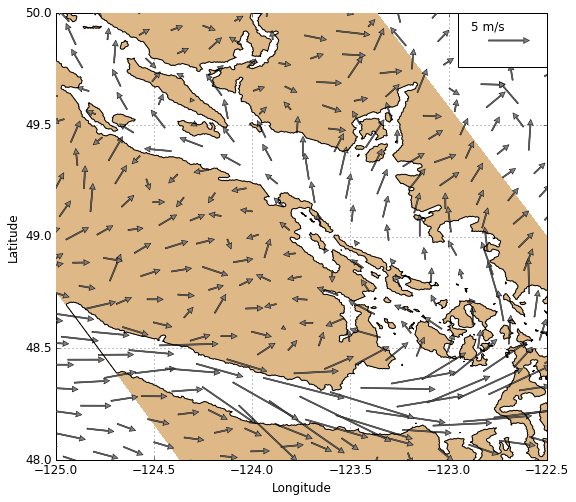

In [16]:
# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Plot surface currents
Q_wind = visualisations.plot_velocity(ax, 'GEM', GEM.isel(time=0),
                    color='gray', scale=60, linewidth=0.5, headwidth=5, mask=False)

# Plot quiver key with a white rectangle
lbox = ax.add_patch(patches.Rectangle((0.82, 0.88), 0.18, 0.12,
                    facecolor='white', transform=ax.transAxes, zorder=10))
Qkey = plt.quiverkey(Q_wind, 0.88, 0.94, 5, '5 m/s', coordinates='axes').set_zorder(11)

### Drifters
Drifters can be plotted using the function `visualisations.plot_drifters`. This function plots them one at a time, taking a given drifter's `xarray` Dataset as input. Use a loop to plot all drifters from a given deployment, and use an index for color control. To plot the drifter track up until a given time, slice the `xarray` Dataset from the beginning of the time record up until that time.

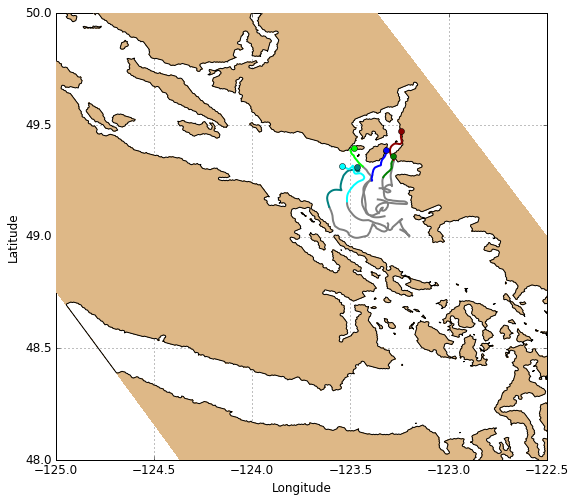

In [17]:
# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Drifter track object storage dict
L_drift = OrderedDict()

# Define color palette for individual tracks
palette = ['blue', 'teal', 'cyan', 'green', 'lime', 'darkred', 'red',
           'orange', 'magenta', 'purple', 'black', 'dimgray', 'saddlebrown']

# Plot drifter tracks (one at a time)
for color, drifter in zip(palette, DRIFTERS['deployment7'].items()):
    L_drift[drifter[0]] = visualisations.plot_drifters(
        ax, drifter[1].sel(time=slice(None, timerange[0])), color=color)

## Animation
Animating a figure is relatively strait-forward once the figure is created. There are 2 key parts to animating a figure:

1. Make a local function that iterates over a timestepping integer. This function contains the code to update specific parts of the figure (e.g., contours, quivers, lines, text, etc.). The plotting functions in the `visualisations` module will do this if the plot objects from the previous timestep are provided as keyword arguments.

2. Pass that function into `matplotlib.animation.FuncAnimation` to produce an animation object, and save the animation object to file using a renderer like FFMpeg.

Below, we'll animate our surface salinity plot. It's helpful to add a timestamp text object so we can see the timestep. It's also helpful when passing multiple plot objects through the animation to combine them into a single dictionary.

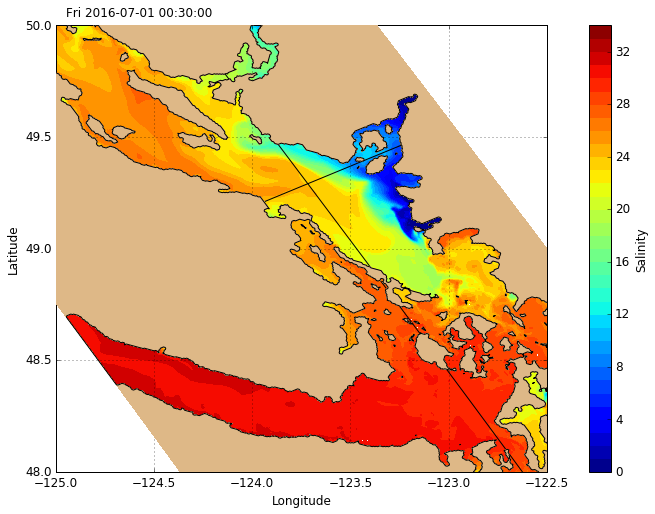

In [19]:
# ------------ FIGURE CODE ------------------

# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Plot surface salinity
C_sal = visualisations.plot_tracers(ax, 'salinity', NEMO.isel(time=0, depth=0))
fig.colorbar(C_sal, label='Salinity')

# Plot sections
ax.plot(NEMO.longitude.isel(gridY=493), NEMO.latitude.isel(gridY=493), 'k-')
ax.plot(NEMO.longitude.isel(gridX=255), NEMO.latitude.isel(gridX=255), 'k-')

# Add timestamp
TXT_time = ax.text(0.02, 1.02, nc_tools.xarraytime_to_datetime(
        NEMO.time[0]).strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)

# ------------ ANIMATION CODE ------------------

# Create dict of objects to be modified with each timestep
PLOT_OBJS = {'C_sal': C_sal, 'TXT_time': TXT_time}

# Create local function that updates these objects (iterates over time integer t)
def next_frame(t, PLOT_OBJS):

    # Update salinity
    PLOT_OBJS['C_sal'] = visualisations.plot_tracers(
        ax, 'salinity', NEMO.isel(time=t, depth=0), C=PLOT_OBJS['C_sal'])
    
    # Update timestamp
    PLOT_OBJS['TXT_time'].set_text(nc_tools.xarraytime_to_datetime(
            NEMO.time[t]).strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

# Call the animation function (create animation object)
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=6)

# Save the animation
ANI.save('/ocean/bmoorema/research/MEOPAR/analysis-ben/visualization/test_movie.mp4',
         writer=animation.FFMpegWriter(fps=12, bitrate=10000))

We can also animate our surface velocity plot.

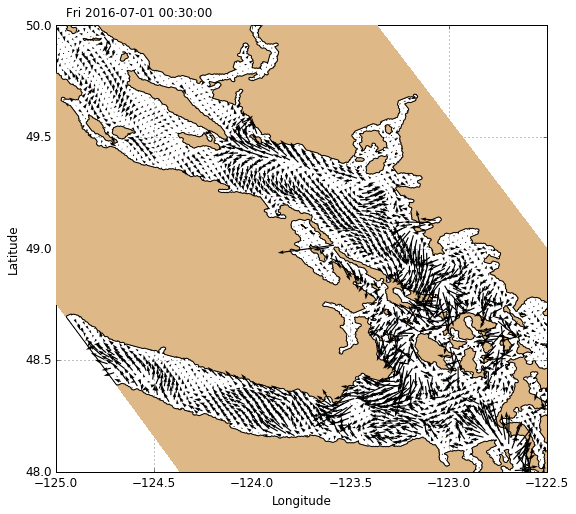

In [20]:
# ------------ FIGURE CODE ------------------

# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Plot surface currents
Q_vel = visualisations.plot_velocity(ax, 'NEMO', NEMO.isel(time=0, depth=0))

# Add timestamp
TXT_time = ax.text(0.02, 1.02, nc_tools.xarraytime_to_datetime(
        NEMO.time[0]).strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)

# ------------ ANIMATION CODE ------------------

# Create dict of objects to be modified with each timestep
PLOT_OBJS = {'Q_vel': Q_vel, 'TXT_time': TXT_time}

# Create local function that updates these objects (iterates over time integer t)
def next_frame(t, PLOT_OBJS):
    
    # Update surface currents
    PLOT_OBJS['Q_vel'] = visualisations.plot_velocity(ax, 'NEMO', NEMO.isel(time=t, depth=0), Q=PLOT_OBJS['Q_vel'])
    
    # Update timestamp
    PLOT_OBJS['TXT_time'].set_text(nc_tools.xarraytime_to_datetime(
            NEMO.time[t]).strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

# Call the animation function (create animation object)
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=6)

# Save the animation
ANI.save('/ocean/bmoorema/research/MEOPAR/analysis-ben/visualization/test_movie.mp4',
         writer=animation.FFMpegWriter(fps=12, bitrate=10000))

Animating the drifters is a little more complicated, since each drifter has it's own unique set of timestamps. In this case, it's easier to define a separate time index. If you wanted to animate multiple layers (e.g., NEMO currents and drifters), this time index could be used to index both datasets.
#### Drifter deployments (2016)

   1. `apr 18 - apr 29 ( 8 tracks)`
   
   2. `may 02 - may 07 ( 2 tracks)`
   
   3. `may 10 - may 22 (12 tracks)`
   
   4. `may 24 - jun 08 ( 9 tracks)`
   
   5. `jun 06 - jun 18 ( 9 tracks)`
   
   6. `jun 14 - jul 08 ( 4 tracks)`
   
   7. `jun 28 - jul 13 ( 6 tracks)`
   
   8. `jul 19 - aug 02 (13 tracks)`
   
   9. `aug 30 - sep 06 ( 6 tracks)`

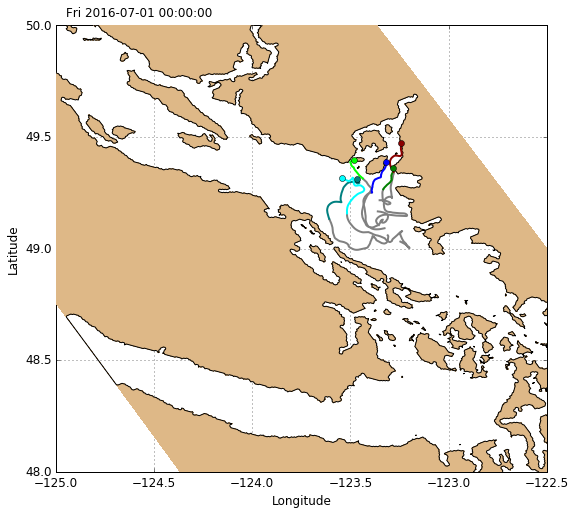

In [21]:
# ------------ FIGURE CODE ------------------

# Create figure
fig, ax = create_figure(NEMO.isel(time=0, depth=0))

# Drifter track object storage dict
L_drift = OrderedDict()

# Define color palette for individual tracks
palette = ['blue', 'teal', 'cyan', 'green', 'lime', 'darkred', 'red',
           'orange', 'magenta', 'purple', 'black', 'dimgray', 'saddlebrown']

# Time index
starttime = parser.parse(timerange[0])

# Plot drifter tracks (one at a time)
for color, drifter in zip(palette, DRIFTERS['deployment7'].items()):
    L_drift[drifter[0]] = visualisations.plot_drifters(
        ax, drifter[1].sel(time=slice(None, starttime)), color=color)

# Add timestamp
TXT_time = ax.text(0.02, 1.02, starttime.strftime('%a %Y-%m-%d %H:%M:%S'), transform=ax.transAxes)

# ------------ ANIMATION CODE ------------------

# Create dict of objects to be modified with each timestep
PLOT_OBJS = {'L_drift': L_drift, 'TXT_time': TXT_time}

# Create local function that updates these objects (iterates over time integer t)
def next_frame(t, PLOT_OBJS):
    
    # Step time index forward
    time_ind = starttime + dtm.timedelta(hours=t)
    
    # Update drifter tracks (one at a time)
    for color, drifter in zip(palette, DRIFTERS['deployment7'].items()):
        PLOT_OBJS['L_drift'][drifter[0]] = visualisations.plot_drifters(
            ax, drifter[1].sel(time=slice(None, time_ind)),
            DRIFT_OBJS=PLOT_OBJS['L_drift'][drifter[0]], color=color)
    
    # Update timestamp
    PLOT_OBJS['TXT_time'].set_text(time_ind.strftime('%a %Y-%m-%d %H:%M:%S'))
    
    return PLOT_OBJS

# Call the animation function (create animation object)
ANI = animation.FuncAnimation(fig, next_frame, fargs=[PLOT_OBJS], frames=6)

# Save the animation
ANI.save('/ocean/bmoorema/research/MEOPAR/analysis-ben/visualization/test_movie.mp4',
         writer=animation.FFMpegWriter(fps=12, bitrate=10000))